In [1]:
#Library importing part
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthBegin
from dateutil.relativedelta import relativedelta
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates 


import requests
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


import h2o
from h2o.automl import H2OAutoML
import xgboost

# Data Scraping and Preparation

## CBA Refinancing Rate

In [2]:
url = "https://www.cba.am/stat/stat_data_eng/8_policy_rates_eng.xlsx"
refinancing_rate = pd.read_excel(url)

print(refinancing_rate)

    Interest rates of the CBA operations in financial market (%)  \
0                                                  NaN             
1                                          Time Period             
2                                27.12.2003-08.03.2004             
3                                09.03.2004-06.04.2004             
4                                07.04.2004-13.07.2004             
..                                                 ...             
139                                        13.03.2024-             
140                                                NaN             
141                                                NaN             
142                                                NaN             
143  1 Untill February 2010 this operation was call...             

            Unnamed: 1          Unnamed: 2     Unnamed: 3  
0                  NaN                 NaN            NaN  
1    Refinancing rates  Deposits Attracted  Lombard Repo1  
2  

In [3]:
# Clean and transform the data
refinancing_rate = (
    refinancing_rate.iloc[2:]
    .rename(columns={
        "Interest rates of the CBA operations in financial market (%)": "Time_Period",
        "Unnamed: 1": "Refinancing_Rates",
        "Unnamed: 2": "Deposits_Attracted",
        "Unnamed: 3": "Lombard_Repo1"
    })
    .filter(['Time_Period', 'Refinancing_Rates'])
    .dropna()
)

# Convert date string from 'Time_Period' to datetime object and set as index
refinancing_rate['Start_Date'] = (
    pd.to_datetime(
        refinancing_rate['Time_Period'].str.split('-').str[0].str.strip(), 
        format='%d.%m.%Y', 
        errors='coerce'
    )
)
refinancing_rate.drop(columns=['Time_Period'], inplace=True)
refinancing_rate.set_index('Start_Date', inplace=True)
# Preview the loaded data
print(refinancing_rate)

           Refinancing_Rates
Start_Date                  
2003-12-27                 9
2004-03-09                 6
2004-04-07                 6
2004-07-14                 5
2004-08-23                 4
...                      ...
2023-09-13              9.75
2023-11-01               9.5
2023-12-13              9.25
2024-01-31              8.75
2024-03-13               8.5

[138 rows x 1 columns]


In [4]:
refinancing_rate.index = refinancing_rate.index.to_period('M')
print(refinancing_rate)

           Refinancing_Rates
Start_Date                  
2003-12                    9
2004-03                    6
2004-04                    6
2004-07                    5
2004-08                    4
...                      ...
2023-09                 9.75
2023-11                  9.5
2023-12                 9.25
2024-01                 8.75
2024-03                  8.5

[138 rows x 1 columns]


In [5]:
refinancing_rate.index = refinancing_rate.index.to_timestamp()

start_date = refinancing_rate.index.min()
end_date = refinancing_rate.index.max()

end_date += relativedelta(months=1)

# Generate all months between start and extended end
current_date = start_date

while current_date <= end_date:
    if current_date not in refinancing_rate.index:
        # Insert NA value for months that do not exist in the DataFrame
        refinancing_rate.at[current_date, 'Refinancing_Rates'] = pd.NA
    current_date += relativedelta(months=1)

# Sort the DataFrame by index after adding missing months
refinancing_rate.sort_index(inplace=True)

# Display the updated DataFrame
print(refinancing_rate.head(15))
print(refinancing_rate.tail())

           Refinancing_Rates
Start_Date                  
2003-12-01                 9
2004-01-01              <NA>
2004-02-01              <NA>
2004-03-01                 6
2004-04-01                 6
2004-05-01              <NA>
2004-06-01              <NA>
2004-07-01                 5
2004-08-01                 4
2004-09-01              <NA>
2004-10-01              3.75
2004-11-01              <NA>
2004-12-01              <NA>
2005-01-01               4.5
2005-02-01              <NA>
           Refinancing_Rates
Start_Date                  
2023-12-01              9.25
2024-01-01              8.75
2024-02-01              <NA>
2024-03-01               8.5
2024-04-01              <NA>


In [6]:
# Fill NaN values with the previous non-NaN value in the Refinancing_Rates column
refinancing_rate['Refinancing_Rates'] = refinancing_rate['Refinancing_Rates'].ffill()


# Display the DataFrame to verify the NaN values are filled
print(refinancing_rate.head(15))  
print(refinancing_rate.tail())

            Refinancing_Rates
Start_Date                   
2003-12-01               9.00
2004-01-01               9.00
2004-02-01               9.00
2004-03-01               6.00
2004-04-01               6.00
2004-05-01               6.00
2004-06-01               6.00
2004-07-01               5.00
2004-08-01               4.00
2004-09-01               4.00
2004-10-01               3.75
2004-11-01               3.75
2004-12-01               3.75
2005-01-01               4.50
2005-02-01               4.50
            Refinancing_Rates
Start_Date                   
2023-12-01               9.25
2024-01-01               8.75
2024-02-01               8.75
2024-03-01               8.50
2024-04-01               8.50


In [7]:
refinancing_rate.index = refinancing_rate.index.to_period('M')
print(refinancing_rate)

            Refinancing_Rates
Start_Date                   
2003-12                  9.00
2004-01                  9.00
2004-02                  9.00
2004-03                  6.00
2004-04                  6.00
...                       ...
2023-12                  9.25
2024-01                  8.75
2024-02                  8.75
2024-03                  8.50
2024-04                  8.50

[249 rows x 1 columns]


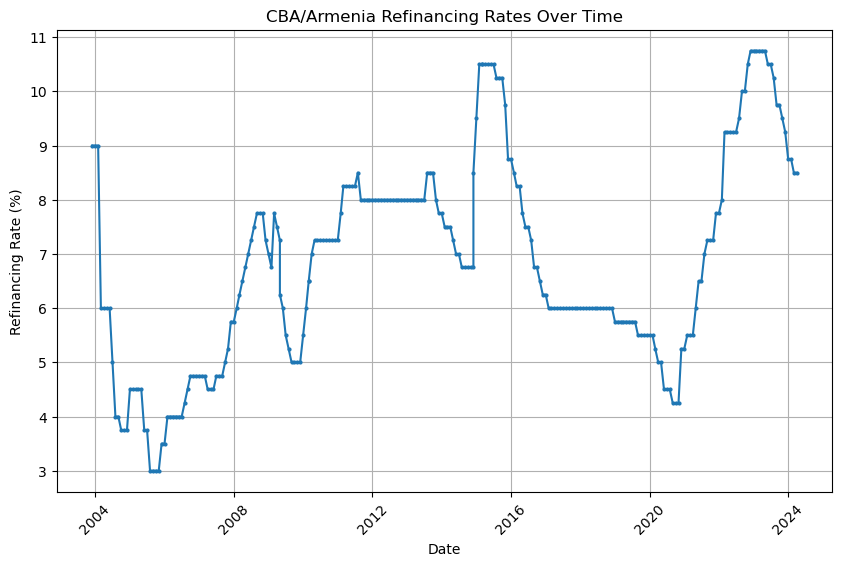

In [8]:
#Convert PeriodIndex to DateTimeIndex
refinancing_rate.index = refinancing_rate.index.to_timestamp()

# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(refinancing_rate.index, refinancing_rate['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.title('CBA/Armenia Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  

# Show the plot
plt.show()

In [9]:
refinancing_rate = refinancing_rate.reset_index()

In [10]:
## Solving the problem of dublicates for concatinating other datasets as well

In [11]:
# Check for duplicated 'Start_Date'
duplicates = refinancing_rate[refinancing_rate['Start_Date'].duplicated(keep=False)]

# Print duplicate rows
print(duplicates)

    Start_Date  Refinancing_Rates
65  2009-05-01               7.25
66  2009-05-01               6.25
76  2010-03-01               6.50
77  2010-03-01               6.50
134 2014-12-01               6.75
135 2014-12-01               8.50
138 2015-03-01              10.50
139 2015-03-01              10.50


In [12]:
# Group by 'Start_Date' and calculate the mean of 'Refinancing_Rates' for each group
refinancing_rate = refinancing_rate.groupby('Start_Date', as_index=False)['Refinancing_Rates'].mean()

In [13]:
refinancing_rate

,Start_Date,Refinancing_Rates
0,2003-12-01,9.00
1,2004-01-01,9.00
2,2004-02-01,9.00
3,2004-03-01,6.00
4,2004-04-01,6.00
...,...,...
240,2023-12-01,9.25
241,2024-01-01,8.75
242,2024-02-01,8.75
243,2024-03-01,8.50


In [14]:
refinancing_rate.set_index('Start_Date', inplace=True)
max_date = refinancing_rate.index.max()
print(max_date)

2024-04-01 00:00:00


In [15]:
refinancing_rate

,Refinancing_Rates
Start_Date,
2003-12-01,9.00
2004-01-01,9.00
2004-02-01,9.00
2004-03-01,6.00
2004-04-01,6.00
...,...
2023-12-01,9.25
2024-01-01,8.75
2024-02-01,8.75


## Georgia policy rate

In [16]:
url = "https://analytics.nbg.gov.ge/views/MonetaryPolicyRate/PolicyRatesTable.csv"

In [17]:
georgia_policy = pd.read_csv(url)

georgia_policy

,Date_,Rate
0,9/12/2008,10.00%
1,9/13/2008,10.00%
2,9/14/2008,10.00%
3,9/15/2008,10.00%
4,9/16/2008,10.00%
...,...,...
5713,5/4/2024,8.25%
5714,5/5/2024,8.25%
5715,5/6/2024,8.25%
5716,5/7/2024,8.25%


In [18]:
# Convert 'Date_' to datetime
georgia_policy['Date_'] = pd.to_datetime(georgia_policy['Date_'])

# Filter to keep only the first day of each month
georgia_policy = georgia_policy[georgia_policy['Date_'].dt.day == 1]

# Your georgia_policy_first_days now contains only the entries for the first day of each month
new_row = pd.DataFrame({'Date_': ['9/1/2008'], 'Rate': ['10.00%']})

# Convert 'Date_' to datetime to match your existing DataFrame
new_row['Date_'] = pd.to_datetime(new_row['Date_'])

# Concatenate the new_row DataFrame with your existing georgia_policy DataFrame
georgia_policy = pd.concat([new_row, georgia_policy], ignore_index=True)

georgia_policy['Rate'] = georgia_policy['Rate'].str.rstrip('%').astype('float') 

In [19]:
georgia_policy

,Date_,Rate
0,2008-09-01,10.00
1,2008-10-01,10.00
2,2008-11-01,10.00
3,2008-12-01,9.00
4,2009-01-01,8.00
...,...,...
184,2024-01-01,9.50
185,2024-02-01,9.00
186,2024-03-01,9.00
187,2024-04-01,8.25


In [20]:
georgia_policy.rename(columns={'Date_': 'Start_Date','Rate':'georgia_rate'}, inplace=True)

In [21]:
georgia_policy_head = refinancing_rate.reset_index()
georgia_policy_head = georgia_policy_head[georgia_policy_head['Start_Date'] <= pd.Timestamp('2008-08-01')]
georgia_policy_head

,Start_Date,Refinancing_Rates
0,2003-12-01,9.00
1,2004-01-01,9.00
2,2004-02-01,9.00
3,2004-03-01,6.00
4,2004-04-01,6.00
5,2004-05-01,6.00
6,2004-06-01,6.00
7,2004-07-01,5.00
8,2004-08-01,4.00
9,2004-09-01,4.00


In [22]:
# Step 1: Rename columns in georgia_policy to ensure consistency
georgia_policy.rename(columns={'georgia_rate': 'Refinancing_Rates'}, inplace=True)

# Convert 'Start_Date' in both DataFrames to datetime to ensure consistency in format
georgia_policy_head['Start_Date'] = pd.to_datetime(georgia_policy_head['Start_Date'])
georgia_policy['Start_Date'] = pd.to_datetime(georgia_policy['Start_Date'])

# Step 2: Concatenate the DataFrames to combine data
georgia_policy = pd.concat([georgia_policy_head, georgia_policy], ignore_index=True)

# Remove duplicate dates to ensure there's no overlap in 'Start_Date'
georgia_policy.drop_duplicates(subset='Start_Date', keep='last', inplace=True)

# Sort by 'Start_Date' to ensure chronological order
georgia_policy.sort_values('Start_Date', inplace=True)

# Reset index to clean up index after sorting
georgia_policy.reset_index(drop=True, inplace=True)

# Display the sorted and cleaned DataFrame
print(georgia_policy)

    Start_Date  Refinancing_Rates
0   2003-12-01               9.00
1   2004-01-01               9.00
2   2004-02-01               9.00
3   2004-03-01               6.00
4   2004-04-01               6.00
..         ...                ...
241 2024-01-01               9.50
242 2024-02-01               9.00
243 2024-03-01               9.00
244 2024-04-01               8.25
245 2024-05-01               8.25

[246 rows x 2 columns]


In [23]:
georgia_policy = georgia_policy[georgia_policy['Start_Date'] <= max_date]

In [24]:
# Convert 'Start_Date' to datetime
georgia_policy['Start_Date'] = pd.to_datetime(georgia_policy['Start_Date'])

# Set 'Start_Date' as index
georgia_policy.set_index('Start_Date', inplace=True)

# Create a full date range from start to end of your data, with monthly frequency
full_range = pd.date_range(start=georgia_policy.index.min(), end=georgia_policy.index.max(), freq='MS')

# Find missing months in your DataFrame
missing_months = full_range.difference(georgia_policy.index)

# Print missing months
print(missing_months)


DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


In [25]:
georgia_policy.rename(columns={'Refinancing_Rates':'georgia_rate'}, inplace=True)

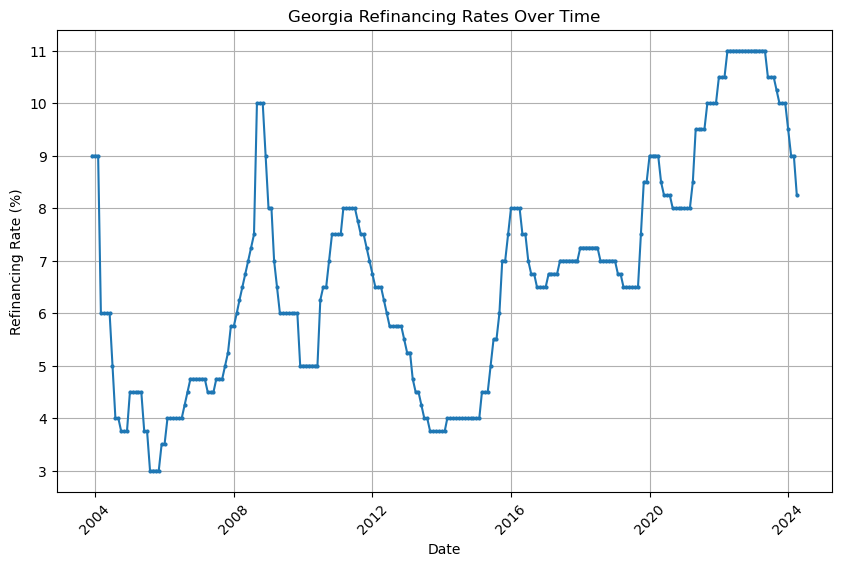

In [26]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(georgia_policy.index, georgia_policy['georgia_rate'], marker='o', linestyle='-', markersize=2)
plt.title('Georgia Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  

# Show the plot
plt.show()

In [27]:
refinancing_rate

,Refinancing_Rates
Start_Date,
2003-12-01,9.00
2004-01-01,9.00
2004-02-01,9.00
2004-03-01,6.00
2004-04-01,6.00
...,...
2023-12-01,9.25
2024-01-01,8.75
2024-02-01,8.75


In [28]:
georgia_policy

,georgia_rate
Start_Date,
2003-12-01,9.00
2004-01-01,9.00
2004-02-01,9.00
2004-03-01,6.00
2004-04-01,6.00
...,...
2023-12-01,10.00
2024-01-01,9.50
2024-02-01,9.00


In [29]:
# Merge the DataFrames on their index
data = pd.merge(refinancing_rate, georgia_policy, left_index=True, right_index=True, how='outer')
data['georgia_rate'].ffill(inplace=True)

In [30]:
data

,Refinancing_Rates,georgia_rate
Start_Date,,
2003-12-01,9.00,9.00
2004-01-01,9.00,9.00
2004-02-01,9.00,9.00
2004-03-01,6.00,6.00
2004-04-01,6.00,6.00
...,...,...
2023-12-01,9.25,10.00
2024-01-01,8.75,9.50
2024-02-01,8.75,9.00


## Russia Refinancing Rate

# IMPORTANT THING TO NOTE. BEFORE RUNNING ALL THE CODE CHECK THIS PART. 
## Below this chunk is russia_rate column data preparatinon part along with the scraping codes. Sometimes the scraping is not working properly. IN CASE THE SCRAPING FAILS THE READY CSV DATA OF THE RATES OF RUSSIA IS IN THE SAME FOLDER. YOU JUST SIMPLY NEED TO UNCOMMENT THE LINE OF CODE BELOW THIS CHUNK.



In [31]:
#Uncomment the two lines here
#russia_rate = pd.read_csv('russia_rate.csv')
#russia_rate['Date'] = pd.to_datetime(russia_rate['Date'], errors='coerce')

In [32]:
# Send the HTTP request and get the response
url1 = "https://www.cbr.ru/eng/statistics/idkp_br/refinancing_rates_e1/"
response = requests.get(url1)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table - make sure to adjust this based on the actual HTML structure
    table = soup.find('table')

    # Initialize an empty list to store the data
    data_scrape = []

    # Loop through each row in the table
    for row in table.find_all('tr'):
        # Extract text from each cell in the row
        cols = [ele.text.strip() for ele in row.find_all('td')]
        # Append the list of text (a single row of data) to the data list if not empty
        if cols:
            data_scrape.append(cols)

    # Create a DataFrame with the collected data
    russia_rate = pd.DataFrame(data_scrape, columns=['Date Range', 'Rate'])
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

# Display the DataFrame to verify contents
print(russia_rate)


                                           Date Range  \
0                                From January 1, 2016   
1   September 14, 2012 — December \r\n\t\t\t\t\t\t...   
2              December 26, 2011 — September 13, 2012   
3                     May 3, 2011 — December 25, 2011   
4                     February 28, 2011 — May 2, 2011   
..                                                ...   
81                       June 2, 1993 — June 21, 1993   
82                      March 30, 1993 — June 1, 1993   
83                      May 23, 1992 — March 29, 1993   
84                      April 10, 1992 — May 22, 1992   
85                    January 1, 1992 — April 9, 1992   

                                                 Rate  
0   Equal to the Bank of Russia key rate \r\n\t\t\...  
1                                                8.25  
2                                                   8  
3                                                8.25  
4                                  

In [33]:
russia_rate[['Start Date', 'End Date']] = russia_rate['Date Range'].str.split('—', expand=True)
russia_rate.drop('Date Range', axis=1, inplace=True)

In [34]:
russia_rate

,Rate,Start Date,End Date
0,Equal to the Bank of Russia key rate \r\n\t\t\...,"From January 1, 2016",None
1,8.25,"September 14, 2012","December \r\n\t\t\t\t\t\t31, 2015"
2,8,"December 26, 2011","September 13, 2012"
3,8.25,"May 3, 2011","December 25, 2011"
4,8,"February 28, 2011","May 2, 2011"
...,...,...,...
81,110,"June 2, 1993","June 21, 1993"
82,100,"March 30, 1993","June 1, 1993"
83,80,"May 23, 1992","March 29, 1993"
84,50,"April 10, 1992","May 22, 1992"


In [35]:
# Assuming russia_rate is your DataFrame
russia_rate = russia_rate.drop(russia_rate.index[0])

In [36]:
# Convert 'Start Date' and 'End Date' to datetime, handling any unparseable dates
russia_rate['Start Date'] = pd.to_datetime(russia_rate['Start Date'], errors='coerce')
russia_rate['End Date'] = pd.to_datetime(russia_rate['End Date'], errors='coerce')

# Cleaning the 'Rate' column to remove unnecessary characters and whitespace
russia_rate['Rate'] = russia_rate['Rate'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Handling specific text in the 'Rate' column to make it more uniform
russia_rate['Rate'] = russia_rate['Rate'].replace({
    'Equal to the Bank of Russia key rate set as of the respective date': 'Variable'
})

# Display the cleaned DataFrame
print(russia_rate)

    Rate Start Date   End Date
1   8.25 2012-09-14 2015-12-31
2      8 2011-12-26 2012-09-13
3   8.25 2011-05-03 2011-12-25
4      8 2011-02-28 2011-05-02
5   7.75 2010-06-01 2011-02-27
..   ...        ...        ...
81   110 1993-06-02 1993-06-21
82   100 1993-03-30 1993-06-01
83    80 1992-05-23 1993-03-29
84    50 1992-04-10 1992-05-22
85    20 1992-01-01 1992-04-09

[85 rows x 3 columns]


In [37]:
print(russia_rate.columns)

Index(['Rate', 'Start Date', 'End Date'], dtype='object')


In [38]:
# Reverse the DataFrame
russia_rate = russia_rate.iloc[::-1].reset_index(drop=True)

# Now russia_rate_reversed will have the earliest dates at the top
print(russia_rate)

    Rate Start Date   End Date
0     20 1992-01-01 1992-04-09
1     50 1992-04-10 1992-05-22
2     80 1992-05-23 1993-03-29
3    100 1993-03-30 1993-06-01
4    110 1993-06-02 1993-06-21
..   ...        ...        ...
80  7.75 2010-06-01 2011-02-27
81     8 2011-02-28 2011-05-02
82  8.25 2011-05-03 2011-12-25
83     8 2011-12-26 2012-09-13
84  8.25 2012-09-14 2015-12-31

[85 rows x 3 columns]


In [39]:
# Create a function to generate the monthly date range for each row
def generate_date_range(start, end):
    return pd.date_range(start=start, end=end, freq='MS')

# Apply the function to each row in the DataFrame
russia_rate['Date Range'] = russia_rate.apply(lambda x: generate_date_range(x['Start Date'], x['End Date']), axis=1)

# Explode the 'Date Range' into separate rows, copying the rate to each row
expanded_data = russia_rate.explode('Date Range').rename(columns={'Date Range': 'Date'})

# Ensure the rate column is aligned with the expanded date ranges
expanded_data['Rate'] = expanded_data['Rate'].ffill()

# Display the result
print(expanded_data)

    Rate Start Date   End Date       Date
0     20 1992-01-01 1992-04-09 1992-01-01
0     20 1992-01-01 1992-04-09 1992-02-01
0     20 1992-01-01 1992-04-09 1992-03-01
0     20 1992-01-01 1992-04-09 1992-04-01
1     50 1992-04-10 1992-05-22 1992-05-01
..   ...        ...        ...        ...
84  8.25 2012-09-14 2015-12-31 2015-08-01
84  8.25 2012-09-14 2015-12-31 2015-09-01
84  8.25 2012-09-14 2015-12-31 2015-10-01
84  8.25 2012-09-14 2015-12-31 2015-11-01
84  8.25 2012-09-14 2015-12-31 2015-12-01

[305 rows x 4 columns]


In [40]:
expanded_data['Date'] = pd.to_datetime(expanded_data['Date'])

expanded_data = expanded_data.drop(columns=['Start Date', 'End Date'])

# Select rows starting from '2003-12-01'
russia_rate_until_2016 = expanded_data[expanded_data['Date'] >= pd.Timestamp('2003-12-01')]

# Print the new DataFrame
print(russia_rate_until_2016)

    Rate       Date
53    16 2003-12-01
53    16 2004-01-01
54    14 2004-02-01
54    14 2004-03-01
54    14 2004-04-01
..   ...        ...
84  8.25 2015-08-01
84  8.25 2015-09-01
84  8.25 2015-10-01
84  8.25 2015-11-01
84  8.25 2015-12-01

[145 rows x 2 columns]


In [41]:
# Define the URL and parameters for the GET request
url = "https://cbr.ru/eng/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2016&UniDbQuery.To=12.04.2024"

# Send the HTTP request and get the response
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table - adjust this based on actual HTML structure
    table = soup.find('table')

    # Initialize an empty list to store data
    data_scrape = []

    # Loop through each row in the table
    for row in table.find_all('tr'):
        # Extract text from each cell in the row
        cols = [ele.text.strip() for ele in row.find_all('td')]
        # Append the list of text (a single row of data) to the data list if not empty
        if cols:
            data_scrape.append(cols)

    # Create a DataFrame with the collected data
    russia_rate_after_2016 = pd.DataFrame(data_scrape, columns=['Date Range', 'Rate'])

    # Display the DataFrame to verify contents
    print(russia_rate_after_2016)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

      Date Range   Rate
0     12.04.2024  16.00
1     11.04.2024  16.00
2     10.04.2024  16.00
3     09.04.2024  16.00
4     08.04.2024  16.00
...          ...    ...
2066  14.01.2016  11.00
2067  13.01.2016  11.00
2068  12.01.2016  11.00
2069  11.01.2016  11.00
2070  01.01.2016  11.00

[2071 rows x 2 columns]


In [42]:
# Convert 'Date Range' from string to datetime format for better sorting and manipulation
russia_rate_after_2016['Date Range'] = pd.to_datetime(
    russia_rate_after_2016['Date Range'], 
    format='%d.%m.%Y'
)

# Sort the DataFrame by 'Date Range'
russia_rate_after_2016.sort_values('Date Range', inplace=True)

# Set 'Date Range' as the DataFrame index
russia_rate_after_2016.set_index('Date Range', inplace=True)

# Resample to get the last known rate of each month
russia_rate_after_2016 = russia_rate_after_2016.resample('M').last()

# Adjust the index to the first of each month for a cleaner and more standardized look
russia_rate_after_2016.index = russia_rate_after_2016.index - pd.offsets.MonthBegin(1)

# Reset index to turn 'Date Range' back into a column, making the DataFrame easier to use in future operations
russia_rate_after_2016.reset_index(inplace=True)

# Display the resulting DataFrame to verify the changes
print(russia_rate_after_2016)

   Date Range   Rate
0  2016-01-01  11.00
1  2016-02-01  11.00
2  2016-03-01  11.00
3  2016-04-01  11.00
4  2016-05-01  11.00
..        ...    ...
95 2023-12-01  16.00
96 2024-01-01  16.00
97 2024-02-01  16.00
98 2024-03-01  16.00
99 2024-04-01  16.00

[100 rows x 2 columns]


In [43]:
russia_rate_after_2016.rename(columns={'Date Range': 'Date'}, inplace=True)


russia_rate = pd.concat([russia_rate_until_2016, russia_rate_after_2016], ignore_index=True)

# Display the combined DataFrame
print(russia_rate)

      Rate       Date
0       16 2003-12-01
1       16 2004-01-01
2       14 2004-02-01
3       14 2004-03-01
4       14 2004-04-01
..     ...        ...
240  16.00 2023-12-01
241  16.00 2024-01-01
242  16.00 2024-02-01
243  16.00 2024-03-01
244  16.00 2024-04-01

[245 rows x 2 columns]


In [44]:
russia_rate = russia_rate.rename(columns={'Rate': 'Russia Rate'})

russia_rate['Russia Rate'] = russia_rate['Russia Rate'].astype(float)

russia_rate

,Russia Rate,Date
0,16.0,2003-12-01
1,16.0,2004-01-01
2,14.0,2004-02-01
3,14.0,2004-03-01
4,14.0,2004-04-01
...,...,...
240,16.0,2023-12-01
241,16.0,2024-01-01
242,16.0,2024-02-01
243,16.0,2024-03-01


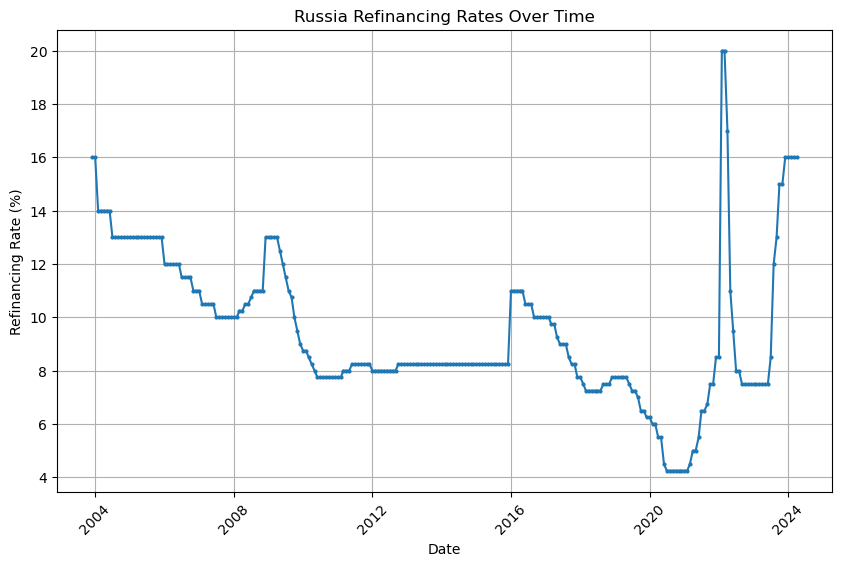

In [45]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(russia_rate['Date'], russia_rate['Russia Rate'], marker='o', linestyle='-', markersize=2)
plt.title('Russia Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  

# Show the plot
plt.show()

In [46]:
data = data.reset_index()

In [47]:
# Merging the DataFrames on their respective date columns
data = pd.merge(data, russia_rate, left_on='Start_Date', right_on='Date', how='outer')


data.drop(columns='Date', inplace=True)

data

,Start_Date,Refinancing_Rates,georgia_rate,Russia Rate
0,2003-12-01,9.00,9.00,16.0
1,2004-01-01,9.00,9.00,16.0
2,2004-02-01,9.00,9.00,14.0
3,2004-03-01,6.00,6.00,14.0
4,2004-04-01,6.00,6.00,14.0
...,...,...,...,...
240,2023-12-01,9.25,10.00,16.0
241,2024-01-01,8.75,9.50,16.0
242,2024-02-01,8.75,9.00,16.0
243,2024-03-01,8.50,9.00,16.0


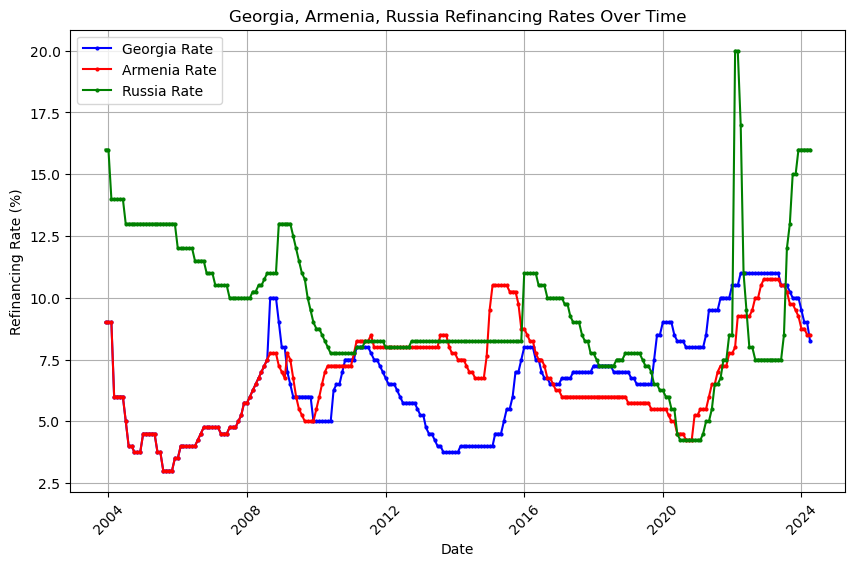

In [48]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(georgia_policy.index, georgia_policy['georgia_rate'], marker='o', linestyle='-', markersize=2, label='Georgia Rate', color='blue')
plt.plot(refinancing_rate.index, refinancing_rate['Refinancing_Rates'], marker='o', linestyle='-', markersize=2, label='Armenia Rate', color='red')
plt.plot(russia_rate['Date'], russia_rate['Russia Rate'], marker='o', linestyle='-', markersize=2, label='Russia Rate', color='green')
plt.title('Georgia, Armenia, Russia Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()  # Add a legend

# Show the plot
plt.show()

### USD/AMD rate integration

In [49]:
url = "https://api.cba.am/ExchangeRatesToCSV.ashx?DateFrom=2003-12-01&DateTo=2024-04-01&ISOCodes=USD"

In [50]:
usd_amd = pd.read_csv(url)
usd_amd

,Ամսաթիվ,USD
01/12/2003,566.17,NaN
02/12/2003,566.55,NaN
03/12/2003,566.55,NaN
04/12/2003,566.34,NaN
05/12/2003,566.53,NaN
...,...,...
26/03/2024,395.68,NaN
27/03/2024,394.71,NaN
28/03/2024,394.46,NaN
29/03/2024,393.28,NaN


In [51]:
usd_amd = pd.DataFrame(usd_amd)

In [52]:
usd_amd['Ամսաթիվ']

01/12/2003    566.17
02/12/2003    566.55
03/12/2003    566.55
04/12/2003    566.34
05/12/2003    566.53
               ...  
26/03/2024    395.68
27/03/2024    394.71
28/03/2024    394.46
29/03/2024    393.28
01/04/2024    391.97
Name: Ամսաթիվ, Length: 5127, dtype: float64

In [53]:
usd_amd.drop(columns='USD', inplace=True)
usd_amd.reset_index(inplace = True)

In [54]:
usd_amd.rename(columns={'Ամսաթիվ': 'USD','index':'Time_Period'}, inplace=True)

In [55]:
usd_amd['Time_Period'] = pd.to_datetime(usd_amd['Time_Period'], format='%d/%m/%Y')

In [56]:
usd_amd.set_index('Time_Period', inplace=True)

usd_amd = usd_amd.resample('M').mean()

usd_amd.index = usd_amd.index + pd.offsets.MonthBegin(-1)

usd_amd.reset_index(inplace = True)
# Print the monthly mean DataFrame
print(usd_amd)

    Time_Period         USD
0    2003-12-01  565.485455
1    2004-01-01  568.441579
2    2004-02-01  564.353810
3    2004-03-01  562.938636
4    2004-04-01  556.864091
..          ...         ...
240  2023-12-01  404.474762
241  2024-01-01  404.960952
242  2024-02-01  404.268095
243  2024-03-01  400.418000
244  2024-04-01  391.970000

[245 rows x 2 columns]


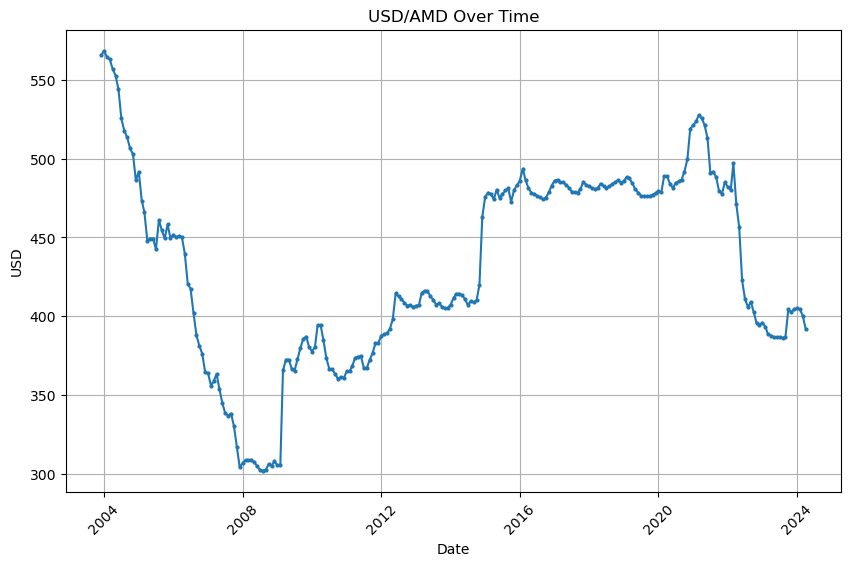

In [57]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(usd_amd['Time_Period'], usd_amd['USD'], marker='o', linestyle='-', markersize=2)
plt.title('USD/AMD Over Time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.xticks(rotation=45)  

# Show the plot
plt.show()

In [58]:
data = pd.merge(data, usd_amd, left_on='Start_Date', right_on='Time_Period', how='outer')
data.drop(columns='Time_Period', inplace=True)

In [59]:
data

,Start_Date,Refinancing_Rates,georgia_rate,Russia Rate,USD
0,2003-12-01,9.00,9.00,16.0,565.485455
1,2004-01-01,9.00,9.00,16.0,568.441579
2,2004-02-01,9.00,9.00,14.0,564.353810
3,2004-03-01,6.00,6.00,14.0,562.938636
4,2004-04-01,6.00,6.00,14.0,556.864091
...,...,...,...,...,...
240,2023-12-01,9.25,10.00,16.0,404.474762
241,2024-01-01,8.75,9.50,16.0,404.960952
242,2024-02-01,8.75,9.00,16.0,404.268095
243,2024-03-01,8.50,9.00,16.0,400.418000


## Dolarization

In [60]:
url = 'https://www.cba.am/stat/stat_data_eng/5_Deposits%20by%20sectors_eng.xlsx'

In [61]:
deposits = pd.read_excel(url)

print(deposits)

    COMMERCIAL BANKS DEPOSITS BY SECTORS OF ECONOMY 1           Unnamed: 1  \
0                            (end of period, mln AMD)                  NaN   
1                                                 NaN                  NaN   
2                                             Column1            Column110   
3                                                 NaN  2000-01-01 00:00:00   
4                                      Non Residents2         33613.476513   
5                                                  FX         31572.713943   
6                                                 AMD           2040.76257   
7                                           Residents         66613.842576   
8                                                 AMD         15730.223768   
9                Demand Deposits (including accounts)         11342.443363   
10                         Non-Financial Corporations          9484.700614   
11                                            Private          6

In [62]:
# Step 1: Extract years and values
years = deposits.iloc[3, 1:]  # Skip the first column which is a description, not a year
residents = deposits.iloc[7, 1:]  # Similarly, skip the description column
fx = deposits.iloc[25, 1:]

# Step 2: Create a new DataFrame with 'Year' and 'Total loans of banking system / GDP' as columns
deposits_new = pd.DataFrame({
    'Time_Period': years.values,
    'Residents': residents.values,  
    'FX': fx.values
})

In [63]:
deposits_new

,Time_Period,Residents,FX
0,2000-01-01,66613.842576,50883.618809
1,2000-02-01,68854.367334,54183.320013
2,2000-03-01,73008.897743,56984.564361
3,2000-04-01,72366.141054,56525.324563
4,2000-05-01,73327.849158,57611.385772
...,...,...,...
286,2023-11-30,4230840.320815,1756651.023428
287,2023-12-31,4320279.315355,1755887.26559
288,2024-01-31,4267342.85177,1744397.570658
289,2024-02-29,4313422.121638,1760710.841821


In [64]:
deposits_new['Dollarization'] = deposits_new['Residents']/deposits_new['FX']

deposits_new = deposits_new.drop('FX', axis = 1)
deposits_new = deposits_new.drop('Residents', axis = 1)

deposits_new['Time_Period'] = pd.to_datetime(deposits_new['Time_Period'])
deposits_new['Dollarization'] = pd.to_numeric(deposits_new['Dollarization'])

In [65]:
deposits_new = deposits_new[deposits_new['Time_Period'] >= '2003-12-01']
deposits_new['Time_Period'] = deposits_new['Time_Period'].dt.to_period('M').dt.to_timestamp()

In [66]:
deposits_new

,Time_Period,Dollarization
47,2003-12-01,1.406075
48,2004-01-01,1.402145
49,2004-02-01,1.378638
50,2004-03-01,1.373693
51,2004-04-01,1.389632
...,...,...
286,2023-11-01,2.408469
287,2023-12-01,2.460454
288,2024-01-01,2.446313
289,2024-02-01,2.449819


In [67]:
data

,Start_Date,Refinancing_Rates,georgia_rate,Russia Rate,USD
0,2003-12-01,9.00,9.00,16.0,565.485455
1,2004-01-01,9.00,9.00,16.0,568.441579
2,2004-02-01,9.00,9.00,14.0,564.353810
3,2004-03-01,6.00,6.00,14.0,562.938636
4,2004-04-01,6.00,6.00,14.0,556.864091
...,...,...,...,...,...
240,2023-12-01,9.25,10.00,16.0,404.474762
241,2024-01-01,8.75,9.50,16.0,404.960952
242,2024-02-01,8.75,9.00,16.0,404.268095
243,2024-03-01,8.50,9.00,16.0,400.418000


In [68]:
# Merge DataFrames on date columns
data = pd.merge(data, deposits_new, left_on='Start_Date', right_on='Time_Period', how='left')

# Drop the additional date column if needed
data.drop(columns=['Time_Period'], inplace=True)

# Fill NA values with the value from the previous month using forward fill
data['Dollarization'].ffill(inplace=True)

In [69]:
data = data.rename(columns={'Start_Date': 'Time_Period'})

In [70]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,USD,Dollarization
0,2003-12-01,9.00,9.00,16.0,565.485455,1.406075
1,2004-01-01,9.00,9.00,16.0,568.441579,1.402145
2,2004-02-01,9.00,9.00,14.0,564.353810,1.378638
3,2004-03-01,6.00,6.00,14.0,562.938636,1.373693
4,2004-04-01,6.00,6.00,14.0,556.864091,1.389632
...,...,...,...,...,...,...
240,2023-12-01,9.25,10.00,16.0,404.474762,2.460454
241,2024-01-01,8.75,9.50,16.0,404.960952,2.446313
242,2024-02-01,8.75,9.00,16.0,404.268095,2.449819
243,2024-03-01,8.50,9.00,16.0,400.418000,2.516169


## Core Inflation

In [71]:
core_inflation = pd.read_excel("https://www.cba.am/stat/stat_data_eng/core_inflation_CBA_eng.xlsx")

# Display the data
print(core_inflation)

    Unnamed: 0                                     CORE INFLATION  \
0          NaN  Seasonal Products &\nAdministrative Regulated ...   
1          NaN    compared to the same month of the previous year   
2       2006/1                                           98.59481   
3       2006/2                                          99.083378   
4       2006/3                                           99.60412   
..         ...                                                ...   
220     2024/3                                          99.290137   
221        NaN                                                NaN   
222          *  currently this indicator is being used for CBA...   
223         **  this indicator is being used for other analyti...   
224        ***  due to consumer basket weights review by SC RA...   

                         Unnamed: 2  \
0                               NaN   
1    compared to the previous month   
2                        100.291715   
3              

In [72]:
core_inflation = core_inflation.iloc[:, [0, 1, 3]]

print(core_inflation)

    Unnamed: 0                                     CORE INFLATION  \
0          NaN  Seasonal Products &\nAdministrative Regulated ...   
1          NaN    compared to the same month of the previous year   
2       2006/1                                           98.59481   
3       2006/2                                          99.083378   
4       2006/3                                           99.60412   
..         ...                                                ...   
220     2024/3                                          99.290137   
221        NaN                                                NaN   
222          *  currently this indicator is being used for CBA...   
223         **  this indicator is being used for other analyti...   
224        ***  due to consumer basket weights review by SC RA...   

                                          Unnamed: 3  
0                    Exclusion & Adjustment method**  
1    compared to the same month of the previous year  
2     

In [73]:
core_inflation.dropna(inplace=True)

print(core_inflation)

    Unnamed: 0 CORE INFLATION  Unnamed: 3
2       2006/1       98.59481   98.743545
3       2006/2      99.083378   99.101892
4       2006/3       99.60412   99.447619
5       2006/4     101.191824  100.872023
6       2006/5     102.216325  101.712238
..         ...            ...         ...
216    2023/11      99.756096  100.990389
217    2023/12      99.606461  100.704472
218  2024/1***      99.559165  100.500455
219     2024/2      99.345842  100.132493
220     2024/3      99.290137   100.13223

[219 rows x 3 columns]


In [74]:
core_inflation.rename(columns={'Unnamed: 0': 'Time_Period', 'CORE INFLATION': 'Core_Inflation_1', 'Unnamed: 3': 'Core_Inflation_2'}, inplace=True)

print(core_inflation)

    Time_Period Core_Inflation_1 Core_Inflation_2
2        2006/1         98.59481        98.743545
3        2006/2        99.083378        99.101892
4        2006/3         99.60412        99.447619
5        2006/4       101.191824       100.872023
6        2006/5       102.216325       101.712238
..          ...              ...              ...
216     2023/11        99.756096       100.990389
217     2023/12        99.606461       100.704472
218   2024/1***        99.559165       100.500455
219      2024/2        99.345842       100.132493
220      2024/3        99.290137        100.13223

[219 rows x 3 columns]


In [75]:
core_inflation['Core_Inflation_1'] = core_inflation['Core_Inflation_1']-100
core_inflation['Core_Inflation_2'] = core_inflation['Core_Inflation_2']-100

print(core_inflation)

    Time_Period Core_Inflation_1 Core_Inflation_2
2        2006/1         -1.40519        -1.256455
3        2006/2        -0.916622        -0.898108
4        2006/3         -0.39588        -0.552381
5        2006/4         1.191824         0.872023
6        2006/5         2.216325         1.712238
..          ...              ...              ...
216     2023/11        -0.243904         0.990389
217     2023/12        -0.393539         0.704472
218   2024/1***        -0.440835         0.500455
219      2024/2        -0.654158         0.132493
220      2024/3        -0.709863          0.13223

[219 rows x 3 columns]


In [76]:
# Remove any extraneous characters (e.g., asterisks)
core_inflation['Time_Period'] = core_inflation['Time_Period'].str.replace('\*\*\*', '', regex=True)

# Specify the exact format of the dates to improve parsing efficiency
date_format = '%Y/%m' 
core_inflation['Time_Period'] = pd.to_datetime(core_inflation['Time_Period'], format=date_format)

In [77]:
core_inflation

,Time_Period,Core_Inflation_1,Core_Inflation_2
2,2006-01-01,-1.40519,-1.256455
3,2006-02-01,-0.916622,-0.898108
4,2006-03-01,-0.39588,-0.552381
5,2006-04-01,1.191824,0.872023
6,2006-05-01,2.216325,1.712238
...,...,...,...
216,2023-11-01,-0.243904,0.990389
217,2023-12-01,-0.393539,0.704472
218,2024-01-01,-0.440835,0.500455
219,2024-02-01,-0.654158,0.132493


In [78]:
# Filter the DataFrame to include only rows on or after 2006-01-01
filtered_data = data[data['Time_Period'] >= pd.Timestamp('2006-01-01')]

In [79]:
# Merge DataFrames on date columns
filtered_data = pd.merge(filtered_data, core_inflation, left_on='Time_Period', right_on='Time_Period', how='left')

# Fill NA values with the value from the previous month using forward fill
filtered_data['Core_Inflation_1'].ffill(inplace=True)
filtered_data['Core_Inflation_2'].ffill(inplace=True)

In [80]:
filtered_data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,USD,Dollarization,Core_Inflation_1,Core_Inflation_2
0,2006-01-01,3.50,3.50,12.0,451.742500,1.511290,-1.405190,-1.256455
1,2006-02-01,4.00,4.00,12.0,450.110000,1.536412,-0.916622,-0.898108
2,2006-03-01,4.00,4.00,12.0,450.998261,1.542730,-0.395880,-0.552381
3,2006-04-01,4.00,4.00,12.0,449.985263,1.548592,1.191824,0.872023
4,2006-05-01,4.00,4.00,12.0,439.731905,1.561499,2.216325,1.712238
...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.0,404.474762,2.460454,-0.393539,0.704472
216,2024-01-01,8.75,9.50,16.0,404.960952,2.446313,-0.440835,0.500455
217,2024-02-01,8.75,9.00,16.0,404.268095,2.449819,-0.654158,0.132493
218,2024-03-01,8.50,9.00,16.0,400.418000,2.516169,-0.709863,0.132230


## Consumer Price Index(CPI)

In [81]:
consumer_price_index = pd.read_excel("https://www.cba.am/stat/stat_data_eng/6_CPI_eng.xls")

# Display the data
print(consumer_price_index)

                     Consumer price index (monthly), %  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                               1996/1   
4                                               1996/2   
..                                                 ...   
341                                             2024/3   
342                                             2024/4   
343                                                NaN   
344  Source: Statistical Committee of the Republic ...   
345  *based on the revised weights of the consumpti...   

                         Unnamed: 1  \
0                               NaN   
1    Compared to the previous month   
2                               CPI   
3                            103.61   
4                        103.378052   
..                              ...   
341                       99.7

In [82]:
consumer_price_index = consumer_price_index.iloc[:, [0, 8]]

print(consumer_price_index)

                     Consumer price index (monthly), %  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                               1996/1   
4                                               1996/2   
..                                                 ...   
341                                             2024/3   
342                                             2024/4   
343                                                NaN   
344  Source: Statistical Committee of the Republic ...   
345  *based on the revised weights of the consumpti...   

                                            Unnamed: 8  
0                                                  NaN  
1                                                  NaN  
2    CPI, compared to the same period of the previo...  
3                                           131.788907  
4                 

In [83]:
consumer_price_index.dropna(inplace=True)

print(consumer_price_index)

    Consumer price index (monthly), %  Unnamed: 8
3                              1996/1  131.788907
4                              1996/2  133.518896
5                              1996/3  133.619388
6                              1996/4  131.187826
7                              1996/5  127.697011
..                                ...         ...
338                           2023/12  101.980419
339                           2024/1*   99.140456
340                            2024/2   98.744512
341                            2024/3   98.762526
342                            2024/4        98.9

[340 rows x 2 columns]


In [84]:
consumer_price_index.rename(columns={'Consumer price index (monthly), %': 'Time_Period', 'Unnamed: 8': 'CPI'}, inplace=True)

print(consumer_price_index)

    Time_Period         CPI
3        1996/1  131.788907
4        1996/2  133.518896
5        1996/3  133.619388
6        1996/4  131.187826
7        1996/5  127.697011
..          ...         ...
338     2023/12  101.980419
339     2024/1*   99.140456
340      2024/2   98.744512
341      2024/3   98.762526
342      2024/4        98.9

[340 rows x 2 columns]


In [85]:
consumer_price_index['CPI'] = consumer_price_index['CPI']-100

print(consumer_price_index)

    Time_Period        CPI
3        1996/1  31.788907
4        1996/2  33.518896
5        1996/3  33.619388
6        1996/4  31.187826
7        1996/5  27.697011
..          ...        ...
338     2023/12   1.980419
339     2024/1*  -0.859544
340      2024/2  -1.255488
341      2024/3  -1.237474
342      2024/4       -1.1

[340 rows x 2 columns]


In [86]:
# Convert 'Time_Period' to datetime format if it's not already
consumer_price_index['Time_Period'] = consumer_price_index['Time_Period'].str.replace('\*', '', regex=True)

date_format = '%Y/%m'  # Adjust this format according to your actual data
consumer_price_index['Time_Period'] = pd.to_datetime(consumer_price_index['Time_Period'], format=date_format)

print(consumer_price_index)

    Time_Period        CPI
3    1996-01-01  31.788907
4    1996-02-01  33.518896
5    1996-03-01  33.619388
6    1996-04-01  31.187826
7    1996-05-01  27.697011
..          ...        ...
338  2023-12-01   1.980419
339  2024-01-01  -0.859544
340  2024-02-01  -1.255488
341  2024-03-01  -1.237474
342  2024-04-01       -1.1

[340 rows x 2 columns]


In [87]:
filtered_consumer_price_index = consumer_price_index[consumer_price_index['Time_Period'] >= pd.Timestamp('2003-12-01')]

print(filtered_consumer_price_index)

    Time_Period       CPI
98   2003-12-01  4.721553
99   2004-01-01  6.914182
100  2004-02-01   7.43394
101  2004-03-01  7.870907
102  2004-04-01  7.878875
..          ...       ...
338  2023-12-01  1.980419
339  2024-01-01 -0.859544
340  2024-02-01 -1.255488
341  2024-03-01 -1.237474
342  2024-04-01      -1.1

[245 rows x 2 columns]


In [88]:
# Merge core_inflation into filtered_data based on a common key (assuming 'Time_Period' is that key and exists in both)
data = filtered_data.merge(consumer_price_index[['Time_Period', 'CPI']], on='Time_Period', how='left')
data['CPI'].ffill(inplace=True)

In [89]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,USD,Dollarization,Core_Inflation_1,Core_Inflation_2,CPI
0,2006-01-01,3.50,3.50,12.0,451.742500,1.511290,-1.405190,-1.256455,-2.973920
1,2006-02-01,4.00,4.00,12.0,450.110000,1.536412,-0.916622,-0.898108,-2.529050
2,2006-03-01,4.00,4.00,12.0,450.998261,1.542730,-0.395880,-0.552381,-2.043668
3,2006-04-01,4.00,4.00,12.0,449.985263,1.548592,1.191824,0.872023,-1.509252
4,2006-05-01,4.00,4.00,12.0,439.731905,1.561499,2.216325,1.712238,-0.729713
...,...,...,...,...,...,...,...,...,...
215,2023-12-01,9.25,10.00,16.0,404.474762,2.460454,-0.393539,0.704472,1.980419
216,2024-01-01,8.75,9.50,16.0,404.960952,2.446313,-0.440835,0.500455,-0.859544
217,2024-02-01,8.75,9.00,16.0,404.268095,2.449819,-0.654158,0.132493,-1.255488
218,2024-03-01,8.50,9.00,16.0,400.418000,2.516169,-0.709863,0.132230,-1.237474


In [90]:
# Extract year and month into new columns
data['Year'] = data['Time_Period'].dt.year
data['Month'] = data['Time_Period'].dt.month

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Time_Period        220 non-null    datetime64[ns]
 1   Refinancing_Rates  220 non-null    float64       
 2   georgia_rate       220 non-null    float64       
 3   Russia Rate        220 non-null    float64       
 4   USD                220 non-null    float64       
 5   Dollarization      220 non-null    float64       
 6   Core_Inflation_1   220 non-null    float64       
 7   Core_Inflation_2   220 non-null    float64       
 8   CPI                220 non-null    float64       
 9   Year               220 non-null    int32         
 10  Month              220 non-null    int32         
dtypes: datetime64[ns](1), float64(8), int32(2)
memory usage: 17.3 KB


## International Reserves

In [92]:
#Had Warning that needs to be ignored
warnings.filterwarnings("ignore", message="Print area cannot be set to Defined name*")


international_reserves_total = pd.read_excel("https://www.cba.am/stat/stat_data_eng/7.International%20reserves_eng.xlsx")

# Display the data
print(international_reserves_total)

                             International Reserves 1           Unnamed: 1  \
0                                       (million USD)                  NaN   
1                                                 NaN                  NaN   
2                                                 NaN  2003-01-01 00:00:00   
3   Gross International Reserves (excluding privat...              421.399   
4                        Gross International Reserves           431.003714   
5                                                Gold            16.304434   
6                                        SDR holdings            26.372314   
7                         Reserve position in the IMF                    0   
8                                  Foreign Exchange 2           388.326965   
9                                                 NaN                  NaN   
10             1 Calculated at actual exchange rates.                  NaN   
11       2 Includes assets in convertible currencies.           

In [93]:
# Step 1: Extract years and values
years = international_reserves_total.iloc[2, 0:]  # Skip the first column which is a description, not a year
reserves = international_reserves_total.iloc[3, 0:]  # Similarly, skip the description column


# Step 2: Create a new DataFrame with 'Year' and 'Total loans of banking system / GDP' as columns
international_reserves_total = pd.DataFrame({
    'Time_Period': years.values,  # Convert to array to ensure proper formatting
    'Reserves': reserves.values
})

international_reserves_total = international_reserves_total.drop(international_reserves_total.index[0])

In [94]:
international_reserves_total

,Time_Period,Reserves
1,2003-01-01 00:00:00,421.399
2,2003-02-01 00:00:00,419.314244
3,2003-03-01 00:00:00,405.2
4,2003-04-01 00:00:00,441.7
5,2003-05-01 00:00:00,455.254348
...,...,...
252,Dec-23 3,NaN
253,2024-01-31 00:00:00,NaN
254,2024-02-28 00:00:00,NaN
255,Mar-24 4,NaN


In [95]:
def parse_custom_dates(date_str):
    # Define potential formats to try
    date_formats = [
        '%Y-%m-%d %H:%M:%S',  # Standard datetime format
        '%b-%y %d'            # Custom format like 'Dec-23 3'
    ]
    
    for fmt in date_formats:
        try:
            # Attempt to convert the date string with the current format
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            # Continue to the next format if there's a ValueError
            continue

    # Log or print the failure after all formats have been tried
    print(f"Failed to parse {date_str}")
    return pd.NaT

In [96]:
international_reserves_total['Time_Period'] = international_reserves_total['Time_Period'].apply(parse_custom_dates)

In [97]:
international_reserves_total = international_reserves_total[international_reserves_total['Time_Period'] >= '2006-01-01']
international_reserves_total = international_reserves_total.copy()
# Convert 'Time_Period' to the first day of each month directly
international_reserves_total['Time_Period'] = international_reserves_total['Time_Period'].dt.to_period('M').dt.to_timestamp()


international_reserves_total

,Time_Period,Reserves
37,2006-01-01,681.873684
38,2006-02-01,669.388861
39,2006-03-01,674.680634
40,2006-04-01,680.035795
41,2006-06-01,744.76195
...,...,...
252,2023-12-01,NaN
253,2024-01-01,NaN
254,2024-02-01,NaN
255,2024-03-01,NaN


In [98]:
data = pd.merge(data, international_reserves_total, left_on='Time_Period', right_on='Time_Period', how='left')

data['Reserves'].ffill(inplace=True)

In [99]:
data['Russia Rate'].ffill(inplace=True)
data['USD'].ffill(inplace=True)

In [100]:
data

,Time_Period,Refinancing_Rates,georgia_rate,Russia Rate,USD,Dollarization,Core_Inflation_1,Core_Inflation_2,CPI,Year,Month,Reserves
0,2006-01-01,3.50,3.50,12.0,451.742500,1.511290,-1.405190,-1.256455,-2.973920,2006,1,681.873684
1,2006-02-01,4.00,4.00,12.0,450.110000,1.536412,-0.916622,-0.898108,-2.529050,2006,2,669.388861
2,2006-03-01,4.00,4.00,12.0,450.998261,1.542730,-0.395880,-0.552381,-2.043668,2006,3,674.680634
3,2006-04-01,4.00,4.00,12.0,449.985263,1.548592,1.191824,0.872023,-1.509252,2006,4,680.035795
4,2006-05-01,4.00,4.00,12.0,439.731905,1.561499,2.216325,1.712238,-0.729713,2006,5,680.035795
...,...,...,...,...,...,...,...,...,...,...,...,...
216,2023-12-01,9.25,10.00,16.0,404.474762,2.460454,-0.393539,0.704472,1.980419,2023,12,2251.613260
217,2024-01-01,8.75,9.50,16.0,404.960952,2.446313,-0.440835,0.500455,-0.859544,2024,1,2251.613260
218,2024-02-01,8.75,9.00,16.0,404.268095,2.449819,-0.654158,0.132493,-1.255488,2024,2,2251.613260
219,2024-03-01,8.50,9.00,16.0,400.418000,2.516169,-0.709863,0.132230,-1.237474,2024,3,2251.613260


# Manually checking Regression Models on the data

## RandomForest

In [101]:
# Determine the split index
split_index = int(len(data) * 0.8)  # 80% of data for training

# Separate the features and the target
X = data.drop(['Refinancing_Rates', 'Time_Period'], axis=1)  # Features
y = data['Refinancing_Rates']  # Target variable

# Split the data using the split index
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


In [102]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate the model
# Assuming you have predictions (y_pred) and actual values (y_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("MSE:", mse_rf)
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)
print("R-squared:", r2_rf)

MSE: 9.381345138888888
RMSE: 3.06289816005836
MAE: 2.5745
R-squared: -1.1527514094083315


In [103]:
y_pred_rf

array([4.6325, 4.665 , 4.665 , 4.665 , 4.6775, 5.2025, 5.24  , 5.2525,
       5.2875, 5.3475, 5.4075, 5.755 , 5.76  , 5.7625, 5.895 , 5.895 ,
       6.2   , 6.165 , 6.34  , 6.325 , 6.3725, 6.405 , 6.3475, 6.36  ,
       6.37  , 6.1425, 6.1425, 6.1425, 6.1375, 6.1025, 6.1275, 6.0575,
       5.945 , 5.8   , 5.7325, 5.58  , 5.505 , 5.56  , 5.56  , 5.57  ,
       5.5525, 5.5975, 5.635 , 5.6475, 5.62  ])

In [104]:
y_pred_rf_df = pd.DataFrame({
    'Date': pd.date_range(start=max_date + pd.DateOffset(months=1), periods=len(y_pred_rf), freq='MS'),
    'Pred': y_pred_rf
})

In [105]:
y_pred_rf_df = y_pred_rf_df[y_pred_rf_df.index < 12]
y_pred_rf_df

,Date,Pred
0,2024-05-01,4.6325
1,2024-06-01,4.6650
2,2024-07-01,4.6650
3,2024-08-01,4.6650
4,2024-09-01,4.6775
5,2024-10-01,5.2025
6,2024-11-01,5.2400
7,2024-12-01,5.2525
8,2025-01-01,5.2875
9,2025-02-01,5.3475


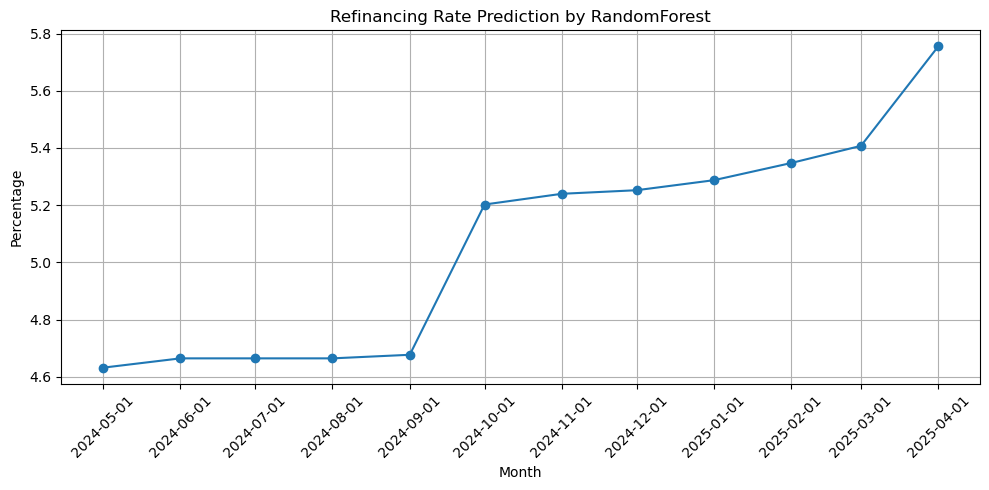

In [106]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_pred_rf_df['Date'], y_pred_rf_df['Pred'], marker='o', linestyle='-')
plt.title('Refinancing Rate Prediction by RandomForest')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(y_pred_rf_df['Date'], y_pred_rf_df['Date'].dt.strftime('%Y-%m-%d'), rotation=45)  # Format x-axis with full date
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

## SVM

In [107]:
# Initialize the model
svm = SVR()

# Fit the model
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the model
# Assuming you have predictions (y_pred) and actual values (y_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print("MSE:", mse_svm)
print("RMSE:", rmse_svm)
print("MAE:", mae_svm)
print("R-squared:", r2_svm)

MSE: 6.161995130259781
RMSE: 2.4823366271035403
MAE: 2.2016670245727927
R-squared: -0.4140023104410733


In [108]:
y_pred_svm

array([6.79284398, 6.79180704, 6.78731092, 6.78022553, 6.76273717,
       6.76099283, 6.75895482, 6.75527294, 6.75721727, 6.7612582 ,
       6.76896015, 6.78923944, 6.78849721, 6.7917494 , 6.79967811,
       6.80115633, 6.79439608, 6.79710705, 6.7985722 , 6.78366543,
       6.80698866, 6.81968942, 6.84854311, 6.8582481 , 6.86256816,
       6.85984315, 6.86506656, 6.87091898, 6.87154815, 6.87036739,
       6.87224201, 6.87595398, 6.87619418, 6.87691129, 6.87654279,
       6.87648137, 6.876698  , 6.87599503, 6.8620119 , 6.86342498,
       6.86177247, 6.86111506, 6.86160797, 6.86472379, 6.87152588])

In [109]:
y_pred_svm_df = pd.DataFrame({
    'Date': pd.date_range(start=max_date + pd.DateOffset(months=1), periods=len(y_pred_svm), freq='MS'),
    'Pred': y_pred_svm
})

In [110]:
y_pred_svm_df = y_pred_svm_df[y_pred_svm_df.index < 12]
y_pred_svm_df

,Date,Pred
0,2024-05-01,6.792844
1,2024-06-01,6.791807
2,2024-07-01,6.787311
3,2024-08-01,6.780226
4,2024-09-01,6.762737
5,2024-10-01,6.760993
6,2024-11-01,6.758955
7,2024-12-01,6.755273
8,2025-01-01,6.757217
9,2025-02-01,6.761258


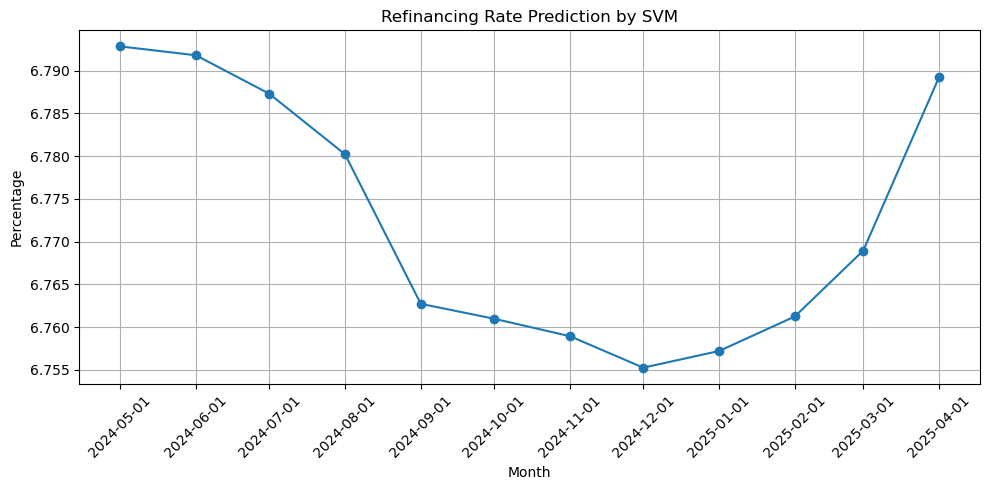

In [111]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_pred_svm_df['Date'], y_pred_svm_df['Pred'], marker='o', linestyle='-')
plt.title('Refinancing Rate Prediction by SVM')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(y_pred_svm_df['Date'], y_pred_svm_df['Date'].dt.strftime('%Y-%m-%d'), rotation=45)  # Format x-axis with full date
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

## GradientBoosting

In [112]:
# Initialize the model
gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model
gbm.fit(X_train, y_train)

# Predict on the test set
y_pred_gbm = gbm.predict(X_test)

# Evaluate the model
# Assuming you have predictions (y_pred) and actual values (y_test)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
rmse_gbm = np.sqrt(mse_gbm)
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print("MSE:", mse_gbm)
print("RMSE:", rmse_gbm)
print("MAE:", mae_gbm)
print("R-squared:", r2_gbm)

MSE: 5.359976141181335
RMSE: 2.315162227832282
MAE: 1.9352104421189729
R-squared: -0.22996180414376832


In [113]:
y_pred_gbm

array([4.60884671, 4.61459392, 4.61459392, 4.59975408, 4.86764508,
       6.95397797, 7.42222465, 7.43789992, 7.441821  , 7.41142405,
       7.55008538, 7.77121097, 7.77121097, 7.91920076, 8.07492499,
       8.06905502, 8.47967209, 8.07278431, 8.62710715, 8.64005995,
       8.61616754, 8.46525491, 8.13274507, 8.28151466, 8.28151466,
       7.88282316, 7.7437589 , 7.73788893, 7.73788893, 7.36053985,
       7.76797353, 7.75035463, 7.32831662, 7.138529  , 7.0940363 ,
       6.26684815, 5.81035566, 5.86528218, 5.88185965, 5.90402588,
       5.90402588, 5.88772245, 5.92769315, 5.93590771, 5.89518557])

In [114]:
y_pred_gbm_df = pd.DataFrame({
    'Date': pd.date_range(start=max_date + pd.DateOffset(months=1), periods=len(y_pred_gbm), freq='MS'),
    'Pred': y_pred_gbm
})

In [115]:
y_pred_gbm_df = y_pred_gbm_df[y_pred_gbm_df.index < 12]
y_pred_gbm_df

,Date,Pred
0,2024-05-01,4.608847
1,2024-06-01,4.614594
2,2024-07-01,4.614594
3,2024-08-01,4.599754
4,2024-09-01,4.867645
5,2024-10-01,6.953978
6,2024-11-01,7.422225
7,2024-12-01,7.437900
8,2025-01-01,7.441821
9,2025-02-01,7.411424


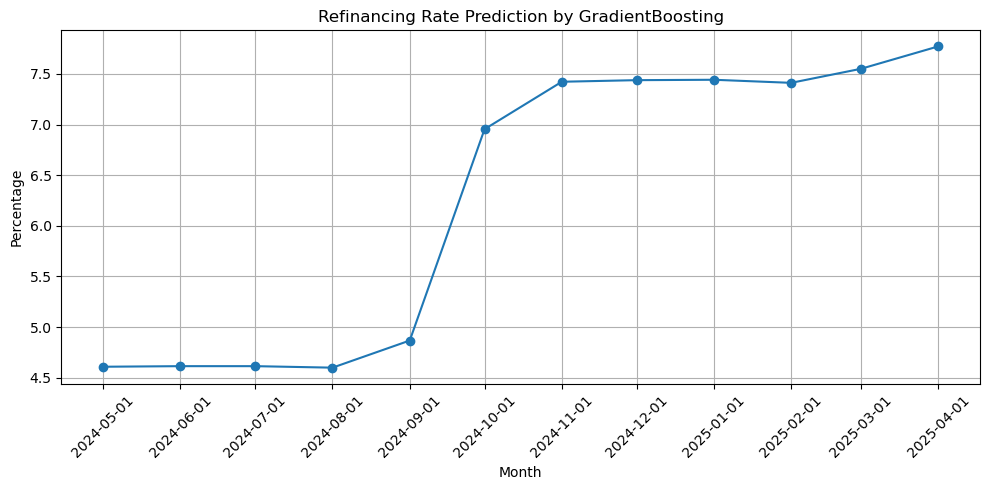

In [116]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_pred_gbm_df['Date'], y_pred_gbm_df['Pred'], marker='o', linestyle='-')
plt.title('Refinancing Rate Prediction by GradientBoosting')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(y_pred_gbm_df['Date'], y_pred_gbm_df['Date'].dt.strftime('%Y-%m-%d'), rotation=45)  # Format x-axis with full date
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

## StackedEnsemble

In [117]:
# Base models
estimators = [
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbm', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('svm', SVR())
]

# Stacked model
stacked_model_rf_gbm_svm = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)

# Fit the stacked model
stacked_model_rf_gbm_svm.fit(X_train, y_train)

# Evaluate the model
y_pred_rf_gbm_svm = stacked_model_rf_gbm_svm.predict(X_test)


# Assuming you have predictions (y_pred) and actual values (y_test)
mse_rf_gbm_svm = mean_squared_error(y_test, y_pred_rf_gbm_svm)
rmse_rf_gbm_svm = np.sqrt(mse_rf_gbm_svm)
mae_rf_gbm_svm = mean_absolute_error(y_test, y_pred_rf_gbm_svm)
r2_rf_gbm_svm = r2_score(y_test, y_pred_rf_gbm_svm)

print("MSE:", mse_rf_gbm_svm)
print("RMSE:", rmse_rf_gbm_svm)
print("MAE:", mae_rf_gbm_svm)
print("R-squared:", r2_rf_gbm_svm)

MSE: 5.074322329951309
RMSE: 2.2526256524223705
MAE: 2.053124858829436
R-squared: -0.16441239351829684


In [118]:
y_pred_rf_gbm_svm

array([5.90410664, 5.88571235, 5.89081074, 5.88230134, 6.19079394,
       8.09904496, 8.59339754, 8.60505661, 8.57924762, 8.49281991,
       8.59071197, 8.53647645, 8.53332159, 8.69261894, 8.75132676,
       8.74310651, 8.9647536 , 8.5360444 , 9.01248091, 9.05581418,
       8.96476395, 8.75614269, 8.3986919 , 8.5435484 , 8.53065664,
       8.27111454, 8.11015843, 8.09697805, 8.1002611 , 7.70889556,
       8.14100653, 8.17310634, 7.79225478, 7.69575938, 7.70052829,
       6.90031734, 6.45110783, 6.46917713, 6.50351439, 6.51863059,
       6.53449223, 6.48109361, 6.49512139, 6.49075478, 6.45962405])

In [119]:
y_pred_rf_gbm_svm_df = pd.DataFrame({
    'Date': pd.date_range(start=max_date + pd.DateOffset(months=1), periods=len(y_pred_rf_gbm_svm), freq='MS'),
    'Pred': y_pred_rf_gbm_svm
})

In [120]:
y_pred_rf_gbm_svm_df = y_pred_rf_gbm_svm_df[y_pred_rf_gbm_svm_df.index < 12]
y_pred_rf_gbm_svm_df

,Date,Pred
0,2024-05-01,5.904107
1,2024-06-01,5.885712
2,2024-07-01,5.890811
3,2024-08-01,5.882301
4,2024-09-01,6.190794
5,2024-10-01,8.099045
6,2024-11-01,8.593398
7,2024-12-01,8.605057
8,2025-01-01,8.579248
9,2025-02-01,8.492820


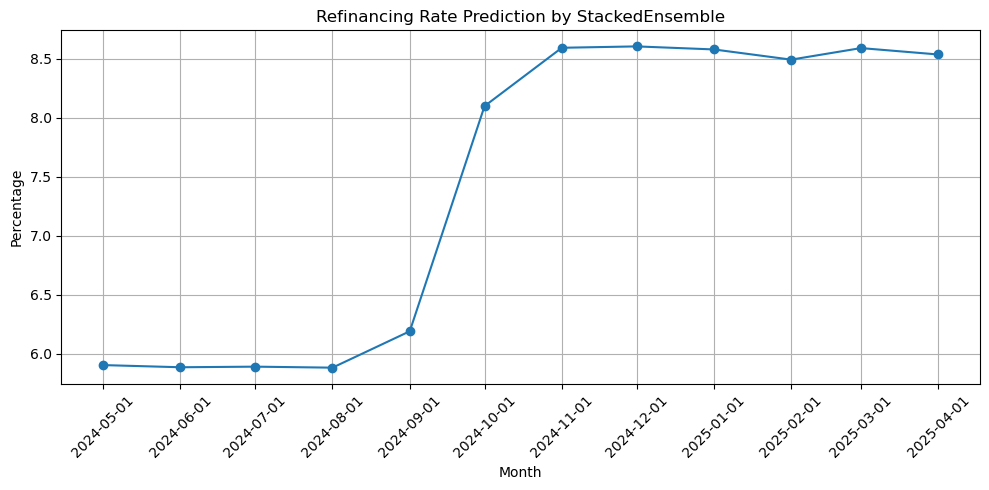

In [121]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_pred_rf_gbm_svm_df['Date'], y_pred_rf_gbm_svm_df['Pred'], marker='o', linestyle='-')
plt.title('Refinancing Rate Prediction by StackedEnsemble')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(y_pred_rf_gbm_svm_df['Date'], y_pred_rf_gbm_svm_df['Date'].dt.strftime('%Y-%m-%d'), rotation=45)  # Format x-axis with full date
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

In [122]:
h2o_data = data

# AutoML Part

In [123]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 days 2 hours 27 mins
H2O_cluster_timezone:,Asia/Yerevan
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_zhorastepanyan_6oa74z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.854 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [124]:
h2o_data = h2o.H2OFrame(h2o_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [125]:
# Assume 'h2o_data' is loaded and available as an H2OFrame
h2o_data = h2o_data.sort(by='Time_Period')
split_point = int(h2o_data.nrow * 0.8)
train = h2o_data.head(rows=split_point)
test = h2o_data.tail(rows=h2o_data.nrow - split_point)

# Setup features and target
y = 'Refinancing_Rates'
x = [col for col in h2o_data.columns if col not in [y,'Time_Period']]  # Assuming 'Time_Period' is not a feature

train[y] = train[y].asnumeric()
test[y] = test[y].asnumeric()

# AutoML configuration
aml = H2OAutoML(max_models=25, seed=1, sort_metric="RMSE")
aml.train(x=x, y=y, training_frame=train)

# Leaderboard and predictions
lb = aml.leaderboard
print(lb)
preds = aml.leader.predict(test)

AutoML progress: |
01:54:29.745: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 176.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse        mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_5_20240509_15429  0.214244  0.0459003  0.153033  0.0286574                 0.0459003
StackedEnsemble_AllModels_1_AutoML_5_20240509_15429     0.229181  0.0525242  0.162254  0.0307578                 0.0525242
XGBoost_2_AutoML_5_20240509_15429                       0.290698  0.0845052  0.205448  0.0374645                 0.0845052
GBM_4_AutoML_5_20240509_15429                           0.29384   0.086342   0.207098  0.039716                  0.086342
GBM_3_AutoML_5_20240509_15429                           0.300041  0.0900246  0.21566   0.0404297                 0.0900246
DeepLearning_

In [126]:
# Assuming 'aml' is your H2OAutoML object
best_model = aml.leader

# Check if the model supports feature importance
if hasattr(best_model, 'varimp'):
    importance = best_model.varimp(use_pandas=True)
    print(importance)
else:
    print("Selected model does not support variable importance.")

None


In [127]:
print("Type of leader model:", type(best_model))
print("Model ID:", best_model.model_id)

Type of leader model: <class 'h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator'>
Model ID: StackedEnsemble_BestOfFamily_1_AutoML_5_20240509_15429


In [128]:
# Get the model ID of another model from the leaderboard that supports variable importance
second_best_model = h2o.get_model(aml.leaderboard[2, 'model_id'])  # Adjust index as needed

# Check for variable importance in the second best model
if hasattr(second_best_model, 'varimp'):
    print(second_best_model.varimp(use_pandas=True))
else:
    print("The second best model also does not support variable importance.")


           variable  relative_importance  scaled_importance  percentage
0              Year           146.899841           1.000000    0.392081
1  Core_Inflation_1            54.529362           0.371201    0.145541
2       Russia Rate            42.419460           0.288765    0.113219
3     Dollarization            41.636120           0.283432    0.111128
4               USD            32.146015           0.218829    0.085799
5          Reserves            14.913290           0.101520    0.039804
6      georgia_rate            14.410746           0.098099    0.038463
7  Core_Inflation_2            11.914435           0.081106    0.031800
8               CPI            11.654952           0.079339    0.031108
9             Month             4.142518           0.028200    0.011057


In [129]:
preds

predict
5.18576
5.24275
5.27428
5.28399
5.4753
6.39167
6.64424
6.95657
7.06939
7.0938


In [130]:
def smooth_transition(historical_df, predicted_df, colname, steps=10):
    """
    Creates a smooth transition from the last actual data point in the historical dataset
    to the first predicted data point in the forecast dataset.

    Parameters:
    - historical_df (pd.DataFrame): DataFrame containing the historical data.
    - predicted_df (pd.DataFrame): DataFrame containing the predicted data.
    - colname (str): The name of the column for which the smooth transition is to be created.
    - steps (int): Number of intermediate steps to generate between the last actual and first predicted values.

    Returns:
    - pd.DataFrame: A DataFrame containing the smoothed transition values followed by the remaining predictions.
    """
    # Validate input
    if colname not in historical_df.columns or colname not in predicted_df.columns:
        raise ValueError(f"Column {colname} must be in both data frames.")
    if historical_df.empty or predicted_df.empty:
        raise ValueError("Input data frames must not be empty.")

    # Extract the last historical value
    last_actual = historical_df[colname].iloc[-1]

    # Extract the first predicted value
    first_predicted = predicted_df[colname].iloc[0]

    # Generate smoothed values between the last actual and the first predicted
    transition_values = np.linspace(last_actual, first_predicted, num=steps + 1, endpoint=False)[1:]

    # Prepare the smoothed transition DataFrame
    transition_df = pd.DataFrame(transition_values, columns=[colname])

    # Concatenate the smoothed transition with the rest of the predictions
    smoothed_predictions = pd.concat([transition_df, predicted_df.iloc[1:]]).reset_index(drop=True)

    return smoothed_predictions

In [131]:
with h2o.utils.threading.local_context(datatable_enabled=True):
    preds_df = preds.as_data_frame()

/Users/zhorastepanyan/opt/anaconda3/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [132]:
# Rename the 'predict' column to 'Refinancing_Rates' in preds_df
preds_df.rename(columns={'predict': 'Refinancing_Rates'}, inplace=True)

# Now run the smoothing transition function
smoothed_predictions_df = smooth_transition(data, preds_df, 'Refinancing_Rates')
print(smoothed_predictions_df.head())


preds_df = smoothed_predictions_df

   Refinancing_Rates
0           8.198705
1           7.897411
2           7.596116
3           7.294821
4           6.993527


In [133]:
smoothed_predictions_df.head()

,Refinancing_Rates
0,8.198705
1,7.897411
2,7.596116
3,7.294821
4,6.993527


In [134]:
date_range = pd.date_range(start=max_date + pd.DateOffset(months=1), periods=len(preds_df), freq='MS')
preds_df.insert(0, 'Date', date_range)

def custom_round(x):
    # Define the target endings
    targets = np.array([0.00, 0.25, 0.5, 0.75])
    # Calculate the base number as an integer part of x
    base = np.floor(x)
    # Find the closest target ending
    closest = targets[np.argmin(np.abs(targets - (x - base)))]
    # Add the closest target ending to the base number
    return base + closest



preds_df['Refinancing_Rates'] = preds_df['Refinancing_Rates'].apply(custom_round)

In [135]:
# Assuming 'preds_df' and 'Date' are defined
preds_df['Start_Date'] = pd.to_datetime(preds_df['Date'])
preds_df.drop('Date', axis=1, inplace=True)  # Clean up the DataFrame by removing the original 'Date' column

# Filter the DataFrame to include only the first 12 entries
# Make an explicit copy after filtering to avoid SettingWithCopyWarning
preds_df = preds_df[preds_df.index <= 11].copy()

# Convert 'Refinancing_Rates' to float using .loc[] to avoid potential future SettingWithCopyWarning
preds_df.loc[:, 'Refinancing_Rates'] = preds_df['Refinancing_Rates'].astype(float)

preds_df  # Display or use the DataFrame

,Refinancing_Rates,Start_Date
0,8.25,2024-05-01
1,7.75,2024-06-01
2,7.50,2024-07-01
3,7.25,2024-08-01
4,6.75,2024-09-01
5,6.75,2024-10-01
6,6.50,2024-11-01
7,6.00,2024-12-01
8,5.75,2025-01-01
9,5.50,2025-02-01


In [136]:
refinancing_rate = refinancing_rate.reset_index()
refinancing_rate

,Start_Date,Refinancing_Rates
0,2003-12-01,9.00
1,2004-01-01,9.00
2,2004-02-01,9.00
3,2004-03-01,6.00
4,2004-04-01,6.00
...,...,...
240,2023-12-01,9.25
241,2024-01-01,8.75
242,2024-02-01,8.75
243,2024-03-01,8.50


In [137]:
# Concatenate the dataframes one after the other along the rows (axis=0)
combined_df = pd.concat([refinancing_rate, preds_df], axis=0)

# Reset the index of the combined dataframe to avoid any duplicate indices
combined_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
combined_df.tail()

,Start_Date,Refinancing_Rates
252,2024-12-01,6.00
253,2025-01-01,5.75
254,2025-02-01,5.50
255,2025-03-01,5.25
256,2025-04-01,5.25


In [138]:
combined_df

,Start_Date,Refinancing_Rates
0,2003-12-01,9.00
1,2004-01-01,9.00
2,2004-02-01,9.00
3,2004-03-01,6.00
4,2004-04-01,6.00
...,...,...
252,2024-12-01,6.00
253,2025-01-01,5.75
254,2025-02-01,5.50
255,2025-03-01,5.25


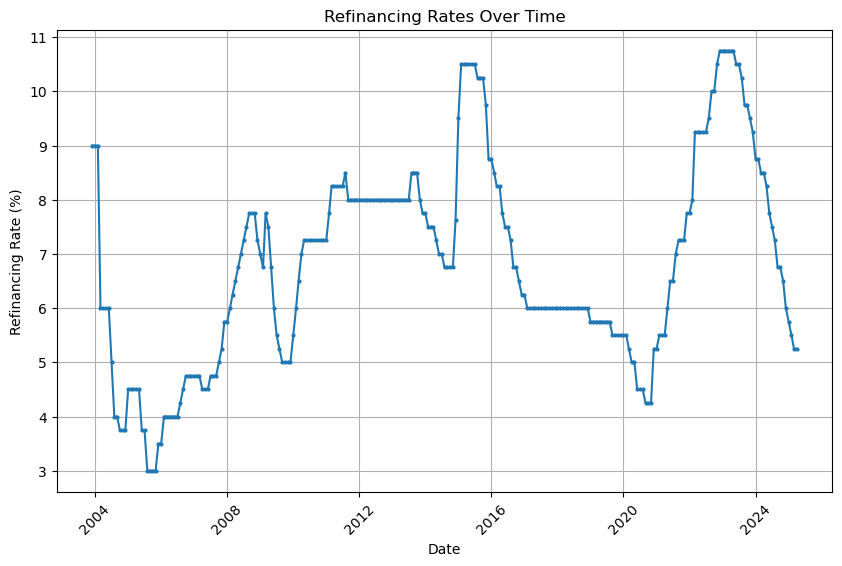

In [139]:
# Now proceed with plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(combined_df['Start_Date'], combined_df['Refinancing_Rates'], marker='o', linestyle='-', markersize=2)
plt.title('Refinancing Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Show the plot
plt.show()

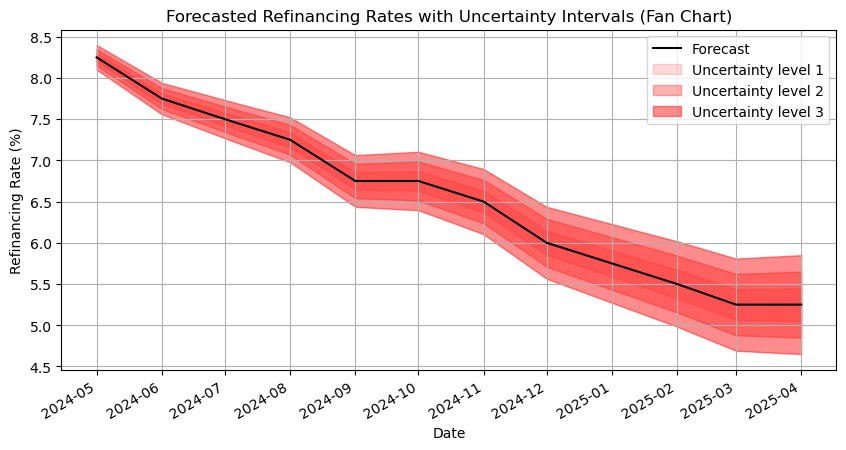

In [140]:
uncertainty = np.linspace(0.05, 0.2, len(preds_df))

# Plot settings
plt.figure(figsize=(10, 5))
plt.plot(preds_df['Start_Date'], preds_df['Refinancing_Rates'], color='black', label='Forecast')

# Add the simulated fan intervals
for i in range(1, 4):  # Creating 3 levels of uncertainty for demonstration
    preds_df['Upper_Bound'] = preds_df['Refinancing_Rates'] + uncertainty * i
    preds_df['Lower_Bound'] = preds_df['Refinancing_Rates'] - uncertainty * i
    plt.fill_between(preds_df['Start_Date'], 
                     preds_df['Lower_Bound'], 
                     preds_df['Upper_Bound'], 
                     color='red', 
                     alpha=0.15 * i,  # Gradually increasing the alpha for each band
                     label=f'Uncertainty level {i}')

# Improve the date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  

# Final plot adjustments
plt.title('Forecasted Refinancing Rates with Uncertainty Intervals (Fan Chart)')
plt.xlabel('Date')
plt.ylabel('Refinancing Rate (%)')
plt.legend()
plt.grid(True)
plt.show()